In [1]:
import os
NUM_THREADS = "12"
os.environ["OMP_NUM_THREADS"] = NUM_THREADS # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = NUM_THREADS # export OPENBLAS_NUM_THREADS=4
os.environ["MKL_NUM_THREADS"] = NUM_THREADS # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = NUM_THREADS # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = NUM_THREADS # export NUMEXPR_NUM_THREADS=6
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py as h5
import tqdm.notebook as tqdm

from lib import *

dx = 0.004149377593360996
dt_imp = 0.00023956442704963727
dt = 4.791288540992745e-06
times.size : 31351
times_imp.size : 628
saved_times.size : 628


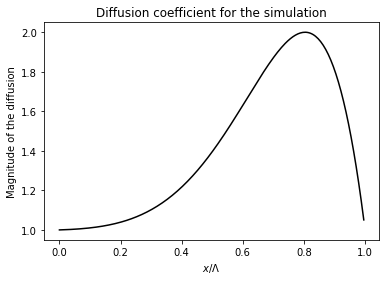

In [2]:
# Spatial discretisation
n=241
Lambda=1
x=Lambda*(np.arange(n)/n)
dx=x[1]-x[0]

# Diffusion coefficient
D = np.arange(n)/(n) + 1
D = np.sin(x*np.pi)*D**8
D = D/D.max() + 1
bDx0 = lambda t : 1
bDxL = lambda t : 1
T_diff = (Lambda/2)**2/D.max()

Lx = 0.1*Lambda
scale = Lx/dx
Lt = Lx**2/(np.sqrt(3)*D[0])
dt_imp = Lt/scale
sub_sampling = 50
dt = dt_imp/sub_sampling

print("dx = {}".format(dx))
print("dt_imp = {}".format(dt_imp))
print("dt = {}".format(dt))
if dt>((0.6*dx**2)/D.max()):
    print("WARNING: CFL condition not satisfied")

# Time window
t_end = 1.2*T_diff + dt_imp
t_end = (t_end//dt_imp)*dt_imp
times = np.arange(0,t_end+dt,dt)
times_imp = times[::sub_sampling]
saved_times = times[::sub_sampling]
print("times.size : {}".format(times.size))
print("times_imp.size : {}".format(times_imp.size))
print("saved_times.size : {}".format(saved_times.size))

# Initial state
c0 = np.ones(n)

# Creates the boundary conditions for the forward and the TL models
bc = 'dirichlet'
bcx0 = lambda t : 1
bcxL = lambda t : 1

bx0 = lambda t : (bcx0(t), bDx0(t))
bxL = lambda t : (bcxL(t), bDxL(t))

model = Diffusion(x=x, D=D, bc=bc, bx0=bx0, bxL=bxL, time_scheme='backward_euler')

plot = True

if plot:
    plt.figure()
    plt.plot(model.x, model.D, c='k')
    plt.xlabel("$x/\Lambda$")
    plt.ylabel("Magnitude of the diffusion")
    plt.title("Diffusion coefficient for the simulation")

In [3]:
V0 = 1
VL = 4

Lt0 = lambda t : Lt
LtL = lambda t : Lt

Vt0 = lambda t : V0
VtL = lambda t : VL

temporal_variances = np.array([[Vt0(t), VtL(t)] for t in times_imp])
temporal_scales = np.array([[Lt0(t), LtL(t)] for t in times_imp])

spatial_variances=np.linspace(V0, VL, n)
spatial_scales=np.zeros(n)+Lx

In [4]:
heterogeneous_boundary_time_serie = BoundaryTimeSerie(model, times_imp,
                                        spatial_variances=spatial_variances,
                                        spatial_scales=spatial_scales,
                                        temporal_variances=temporal_variances,
                                        temporal_scales = temporal_scales,
                                        transition_scale = dx/dt_imp,
                                        offset = max(times_imp.size,n)
                                       )

  0%|          | 0/1497 [00:00<?, ?it/s]

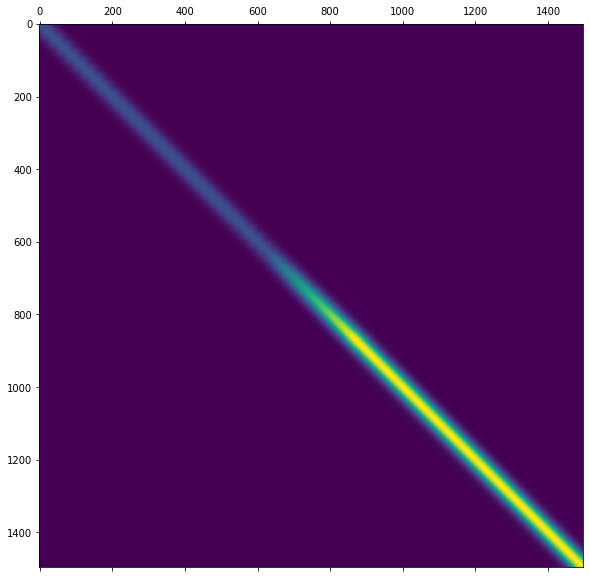

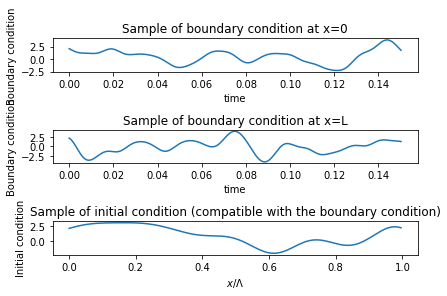

In [5]:
if plot:
    heterogeneous_boundary_time_serie.show_covariances()

    initial_condition, random_bc0, random_bcL = heterogeneous_boundary_time_serie.boundary_condition_factory()
    plt.figure()
    plt.subplot(311)
    heterogeneous_boundary_time_serie.plot_boundary_condition(random_bc0)
    plt.title("Sample of boundary condition at x=0");
    plt.subplot(312)
    heterogeneous_boundary_time_serie.plot_boundary_condition(random_bcL)
    plt.title("Sample of boundary condition at x=L");
    plt.subplot(313)
    plt.plot(model.x, initial_condition)
    plt.title("Sample of initial condition (compatible with the boundary condition)");
    plt.xlabel("$x/\Lambda$")
    plt.ylabel("Initial condition")
    plt.tight_layout()

    plt.show()

In [6]:
heterogeneous_enkf_experiment = EnKFExperiment(model, heterogeneous_boundary_time_serie)
Ne = 6400
heterogeneous_enkf_experiment.run_ensemble(Ne=Ne, times=times_imp, saved_times=saved_times, initial_condition=np.ones(n), bx0=bx0, bxL=bxL)

  0%|          | 0/6400 [00:00<?, ?it/s]

In [7]:
pkf_bx0 = lambda t : (bcx0(t), Vt0(t), np.sqrt(3*(bDx0(t)*Lt0(t))**2), bDx0(t))
pkf_bxL = lambda t : (bcxL(t), VtL(t), np.sqrt(3*(bDxL(t)*LtL(t))**2), bDxL(t))

pkf_model = DiffusionPKF(x=x, D=D, bc=bc, bx0=pkf_bx0, bxL=pkf_bxL, time_scheme='rk4')

pkf_state0 = np.zeros((3,n))
pkf_state0[0][:] = 1
pkf_state0[1][:] = spatial_variances
pkf_state0[2][:] = spatial_scales**2

pkf_traj = pkf_model.forecast(times, pkf_state0, saved_times=saved_times)

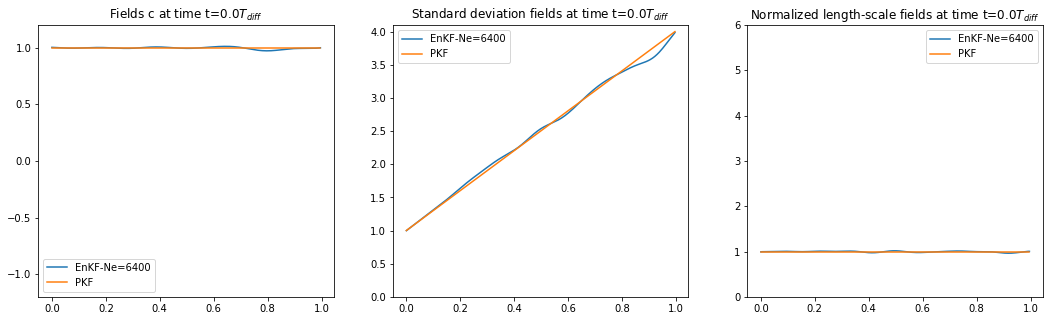

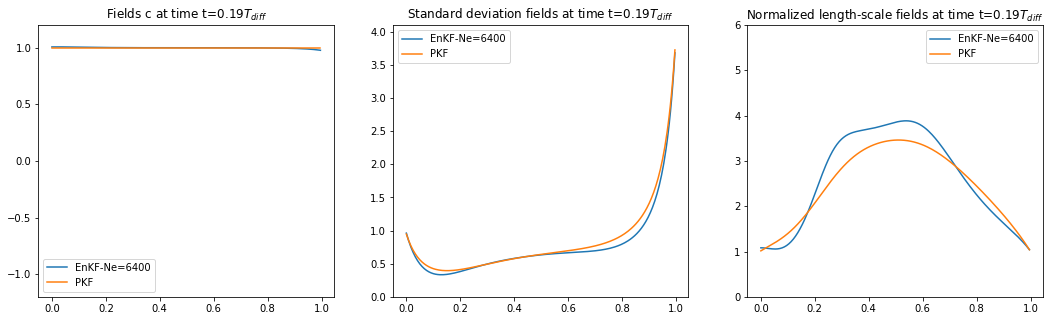

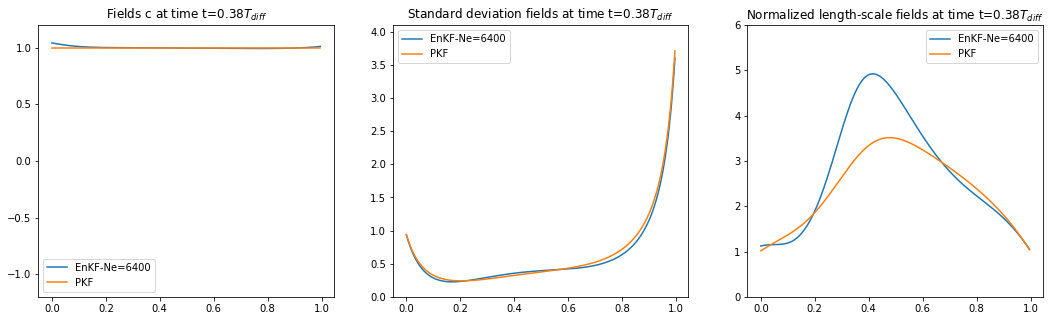

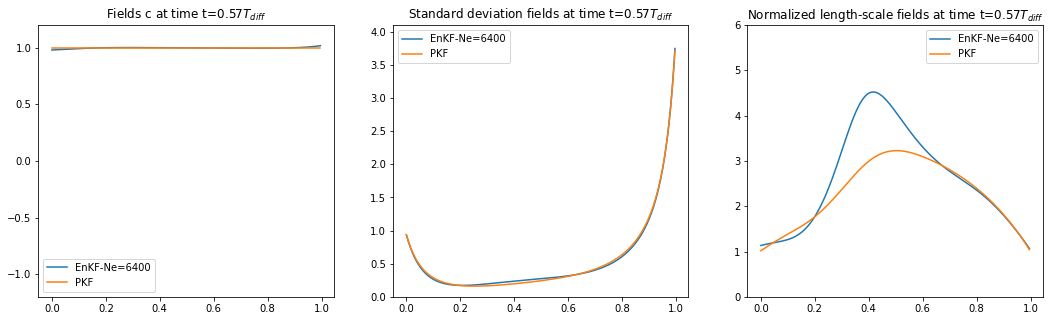

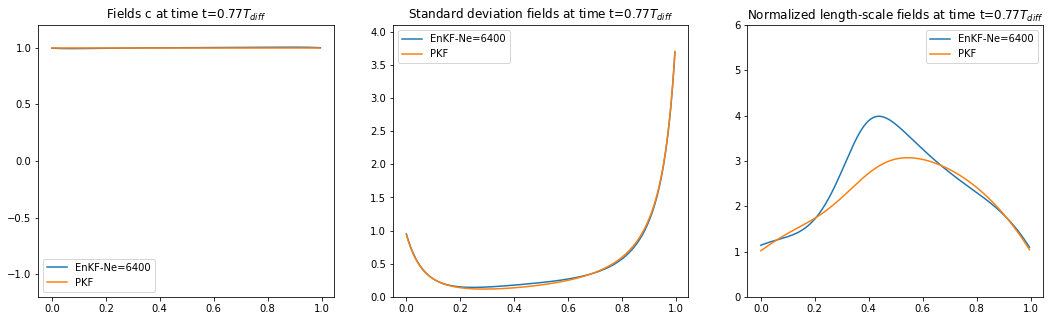

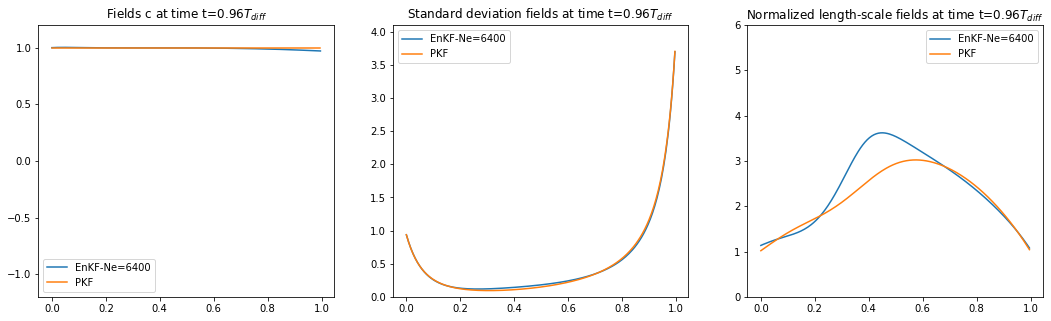

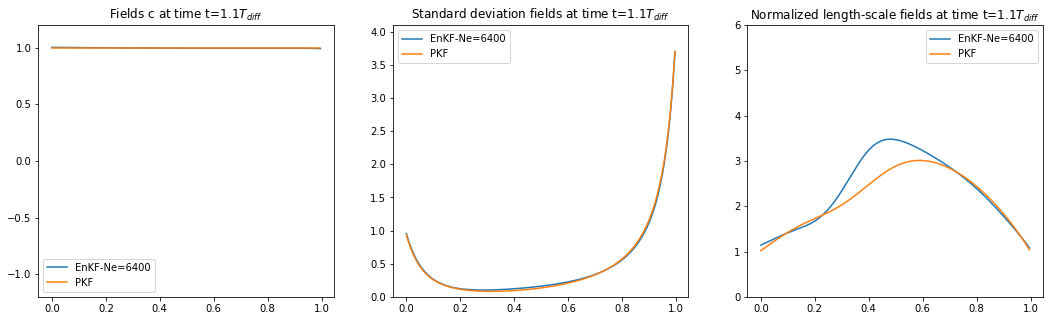

In [8]:
def plot_compare_at_t(t):
    plt.figure(figsize=(18,5))

    plt.subplot(131)
    plt.plot(model._x, heterogeneous_enkf_experiment.mean[t], label='EnKF-Ne={}'.format(heterogeneous_enkf_experiment.Ne))
    plt.plot(model._x, pkf_traj[t][0], label='PKF')
    plt.ylim(-1.2,1.2)
    plt.title(f"Fields c at time t={t/T_diff:1.2}"+"$T_{diff}$")
    plt.legend()

    plt.subplot(132)
    plt.plot(model._x, heterogeneous_enkf_experiment.variances[t], label='EnKF-Ne={}'.format(heterogeneous_enkf_experiment.Ne))
    plt.plot(model._x, pkf_traj[t][1], label='PKF')
    plt.ylim(0,4.1)
    plt.title(f"Standard deviation fields at time t={t/T_diff:1.2}"+"$T_{diff}$")
    plt.legend()

    plt.subplot(133)
    plt.plot(model.x, heterogeneous_enkf_experiment.length_scales[t]/Lx,label=f'EnKF-Ne={heterogeneous_enkf_experiment.Ne}')
    plt.plot(model.x, np.sqrt(pkf_traj[t][2])/Lx,label='PKF')
    #plt.plot(model.x, np.sqrt(pkf_traj_unclosed[t][2])/model._dx,label='PKF EnKF-closure')
    plt.ylim(0,6)
    plt.title(f"Normalized length-scale fields at time t={t/T_diff:1.2}"+'$T_{diff}$')
    plt.legend()

if plot:
    for t in saved_times[::100]:
        plot_compare_at_t(t)
        plt.show()

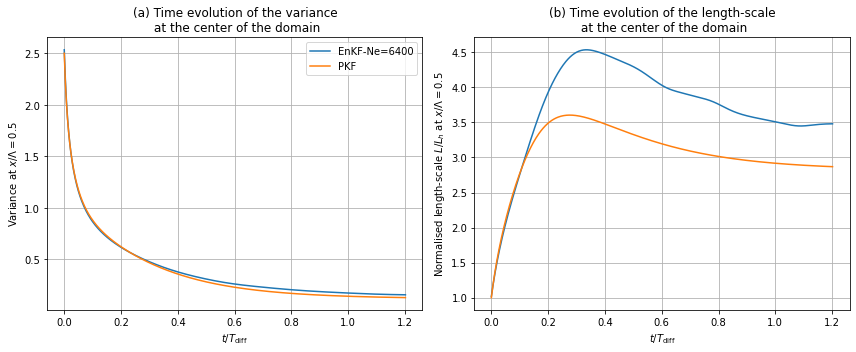

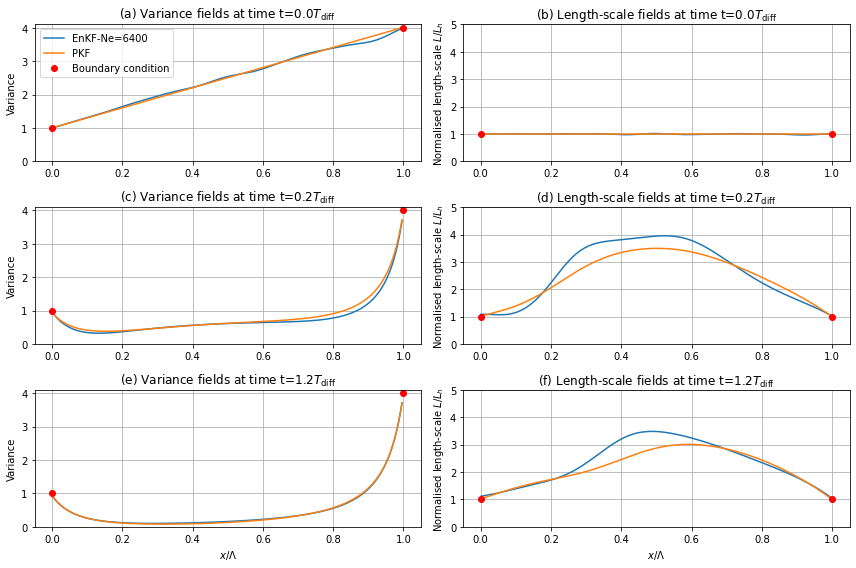

In [9]:
if plot:
    plt.figure(figsize=(12,5))

    plt.subplot(121)
    plt.plot(saved_times/T_diff, [heterogeneous_enkf_experiment.variances[t][120] for t in saved_times], label='EnKF-Ne={}'.format(heterogeneous_enkf_experiment.Ne))
    plt.plot(saved_times/T_diff, [pkf_traj[t][1][120] for t in saved_times], label='PKF')
    plt.title('(a) Time evolution of the variance\n at the center of the domain')
    plt.xlabel('$t/T_{\mathrm{diff}}$')
    plt.ylabel('Variance at $x/\Lambda=0.5 $')
    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.plot(saved_times/T_diff, [heterogeneous_enkf_experiment.length_scales[t][120]/Lx for t in saved_times], label='EnKF-Ne={}'.format(heterogeneous_enkf_experiment.Ne))
    plt.plot(saved_times/T_diff, [np.sqrt(pkf_traj[t][2][120])/Lx for t in saved_times], label='PKF')
    plt.title('(b) Time evolution of the length-scale\n at the center of the domain')
    plt.xlabel('$t/T_{\mathrm{diff}}$')
    plt.ylabel('Normalised length-scale $L/L_h$ at $x/\Lambda=0.5 $')
    plt.grid()

    plt.tight_layout()

    plt.savefig('../figures/PKF-heterogeneous-diffusion-dirichlet-timeseries.pdf')

plot_times = [0, 105, -1]
letters = 'abcdef'

if plot:
    plt.figure(figsize=(12,8))

    for i in range(3):
        index = plot_times[i]
        plt.subplot(321 + 2*i)
        plt.plot(model._x, heterogeneous_enkf_experiment.variances[saved_times[index]], label='EnKF-Ne={}'.format(heterogeneous_enkf_experiment.Ne))
        plt.plot(model._x, pkf_traj[saved_times[index]][1], label='PKF')
        plt.plot(0, pkf_bx0(saved_times[index])[1], 'ro', label='Boundary condition')
        plt.plot(1, pkf_bxL(saved_times[index])[1], 'ro')
        plt.ylim(0,4.1)
        plt.title("("+letters[2*i]+")"+f" Variance fields at time t={saved_times[index]/T_diff:1.2}"+"$T_{\mathrm{diff}}$")
        plt.ylabel('Variance')
        if i==0:
            plt.legend()
        if i==2:
            plt.xlabel("$x/\Lambda$")
        plt.grid()

        plt.subplot(322 + 2*i)
        plt.plot(model.x, heterogeneous_enkf_experiment.length_scales[saved_times[index]]/Lx,label=f'EnKF-Ne={heterogeneous_enkf_experiment.Ne}')
        plt.plot(model.x, np.sqrt(pkf_traj[saved_times[index]][2])/Lx,label='PKF')
        plt.plot(0, np.sqrt(pkf_bx0(saved_times[index])[2])/Lx, 'ro')
        plt.plot(1, np.sqrt(pkf_bxL(saved_times[index])[2])/Lx, 'ro')
        plt.ylim(0,5)
        plt.title("("+letters[2*i+1]+")"+f" Length-scale fields at time t={saved_times[index]/T_diff:1.2}"+'$T_{\mathrm{diff}}$')
        plt.ylabel('Normalised length-scale $L/L_h$')
        if i==2:
            plt.xlabel("$x/\Lambda$")
        plt.grid()

    plt.tight_layout()
    plt.savefig('../figures/PKF-heterogeneous-diffusion-dirichlet-time-comparison.pdf')